In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import get_scheduler
import logging

/home/dmitrii/micromamba/envs/spbrag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
df = pd.read_csv("../data/merged.csv")
df.head()

,category,prompt,need_retrieval
0,closed_qa,Is the capital city and the largest city of Ch...,0
1,NaN,Change the text into a historical reenactment ...,0
2,NaN,Make the text into a cyberpunk hacker's manife...,0
3,NaN,Make the text into a weather forecast script T...,0
4,NaN,Describe this as a arrangement to be arranged....,0


The dataset is imbalanced, meaning some classes have significantly more examples than others. \
To address this and ensure fair representation, I decided to use a balanced subset of the data. \
Specifically, I limited the dataset to 1,500 examples per class. \
This approach helps prevent the model from being biased toward the majority class while still providing enough data for training.

In [3]:
num_samples_per_class = 1500
balanced_df = (
    df.groupby("need_retrieval", group_keys=False)
    .apply(lambda x: x.sample(num_samples_per_class, random_state=42), include_groups=True)
    .reset_index(drop=True)
)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipykernel_12313/150601467.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(num_samples_per_class, random_state=42), include_groups=True)


In [4]:
balanced_df.head()

,category,prompt,need_retrieval
0,creative_writing,Is it better to run or to walk?,1
1,closed_qa,What did Jordan Akins do after retiring from b...,0
2,general_qa,My daughter's friend is lactose intolerant. Wh...,1
3,NaN,Write like a pioneer: Adopt the hopeful and de...,0
4,creative_writing,How do you improve your basketball handles?,1


In [5]:
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## Tokenizer

"bert-base-uncased is an effective model for understanding language patterns. \
Its Transformer architecture captures complex word relationships, and its uncased nature simplifies text processing. \
Widely supported and easy to fine-tune, it’s a strong choice for many NLP tasks.

The authors of the article used BERT-basemultilingual-cased. \
I will use only English, therefore there is no need to use multilingual BERT.

In [6]:
tokenizer_path = "bert-base-uncased"
tokenizer_path = "./bert-text-classification-model"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)


def tokenize_data(df, tokenizer, max_length=128):
    return tokenizer(
        df["prompt"].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )

In [7]:
model_path = "bert-base-uncased"
model_path = "./bert-text-classification-model"
num_labels = 2

model = BertForSequenceClassification.from_pretrained(
    model_path, num_labels=num_labels
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)
test_encodings = tokenize_data(test_df, tokenizer)

In [9]:
class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels, indices):
        self.encodings = encodings
        self.labels = labels
        self.indices = indices

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["idx"] = torch.tensor(self.indices[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_labels = train_df["need_retrieval"].tolist()
val_labels = val_df["need_retrieval"].tolist()
test_labels = test_df["need_retrieval"].tolist()

# saving the indices of specific samples in the dataset so that I can easily retrieve them later when needed
train_indices = train_df.index.tolist()
val_indices = val_df.index.tolist()
test_indices = test_df.index.tolist()


train_dataset = TextClassificationDataset(train_encodings, train_labels, train_indices)
val_dataset = TextClassificationDataset(val_encodings, val_labels, val_indices)
test_dataset = TextClassificationDataset(test_encodings, test_labels, test_indices)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

/home/dmitrii/micromamba/envs/spbrag/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)


def train_epoch(model, train_loader, optimizer, lr_scheduler, device):
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    for batch in tqdm(train_loader, desc="Training", leave=False):
        batch = {k: v.to(device) for k, v in batch.items() if k != 'idx'}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(batch["labels"].cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds)

    return avg_train_loss, train_accuracy, train_f1


def validate_epoch(model, val_loader, device):
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            batch = {k: v.to(device) for k, v in batch.items() if k != 'idx'}
            outputs = model(**batch)
            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    return avg_val_loss, val_accuracy, val_f1

In [ ]:
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    lr_scheduler,
    device,
    num_epochs: int,
    save_dir: str = "./bert-text-classification-model",
    metric: str = "f1",
    early_stopping_patience=None,
):
    best_val_metric = 0
    epochs_without_improvement = 0

    metrics = {
        "train_losses": [],
        "val_losses": [],
        "train_accuracies": [],
        "val_accuracies": [],
        "train_f1_scores": [],
        "val_f1_scores": [],
    }

    for epoch in range(num_epochs):
        logger.info(f"Epoch {epoch + 1}/{num_epochs}")

        avg_train_loss, train_accuracy, train_f1 = train_epoch(
            model, train_loader, optimizer, lr_scheduler, device
        )
        metrics["train_losses"].append(avg_train_loss)
        metrics["train_accuracies"].append(train_accuracy)
        metrics["train_f1_scores"].append(train_f1)
        logger.info(
            f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training F1: {train_f1:.4f}"
        )

        avg_val_loss, val_accuracy, val_f1 = validate_epoch(model, val_loader, device)
        metrics["val_losses"].append(avg_val_loss)
        metrics["val_accuracies"].append(val_accuracy)
        metrics["val_f1_scores"].append(val_f1)
        logger.info(
            f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}"
        )

        current_val_metric = val_f1 if metric == "f1" else val_accuracy

        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            model.save_pretrained(save_dir)
            logger.info(
                f"New best model saved with Validation {metric.capitalize()}: {best_val_metric:.4f}"
            )
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if (
            early_stopping_patience
            and epochs_without_improvement >= early_stopping_patience
        ):
            logger.info(f"Early stopping at epoch {epoch + 1} due to no improvement.")
            break

    logger.info(
        f"Loaded the best model with Validation {metric.capitalize()}: {best_val_metric:.4f}"
    )

    return metrics

In [13]:
metrics = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
    num_epochs=4,
    save_dir='./bert-text-classification-model',
    metric="f1",
    early_stopping_patience=3,
)


train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_f1_scores = metrics["train_f1_scores"]
val_f1_scores = metrics["val_f1_scores"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]

2025-02-01 14:42:45,306 - INFO - Epoch 1/4
2025-02-01 14:44:22,003 - INFO - Training Loss: 0.0603, Training Accuracy: 0.9867, Training F1: 0.9869
2025-02-01 14:44:29,859 - INFO - Validation Loss: 0.0252, Validation Accuracy: 0.9956, Validation F1: 0.9952
2025-02-01 14:44:30,573 - INFO - New best model saved with Validation F1: 0.9952
2025-02-01 14:44:30,574 - INFO - Epoch 2/4
2025-02-01 14:46:08,929 - INFO - Training Loss: 0.0279, Training Accuracy: 0.9938, Training F1: 0.9939
2025-02-01 14:46:17,321 - INFO - Validation Loss: 0.0238, Validation Accuracy: 0.9978, Validation F1: 0.9976
2025-02-01 14:46:18,080 - INFO - New best model saved with Validation F1: 0.9976
2025-02-01 14:46:18,081 - INFO - Epoch 3/4
2025-02-01 14:47:53,593 - INFO - Training Loss: 0.0175, Training Accuracy: 0.9957, Training F1: 0.9958
2025-02-01 14:48:01,550 - INFO - Validation Loss: 0.0133, Validation Accuracy: 0.9978, Validation F1: 0.9976
2025-02-01 14:48:01,551 - INFO - Epoch 4/4
2025-02-01 14:49:43,149 - INFO

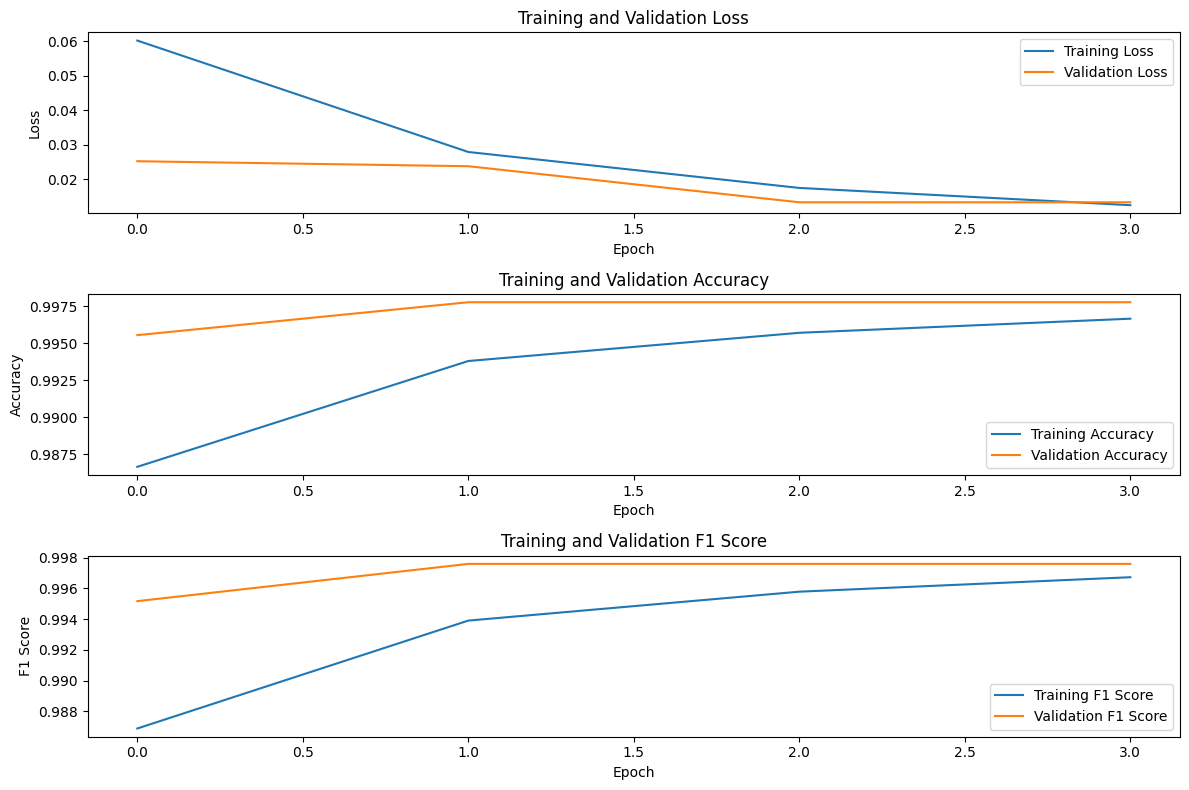

In [14]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_f1_scores, label='Training F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
def evaluate(
    model,
    test_loader,
    test_df,
    device,
):
    model.eval()
    test_results = []

    with torch.no_grad():
        for batch in test_loader:
            idxs = batch["idx"].cpu().numpy()
            batch = {k: v.to(device) for k, v in batch.items() if k != "idx"}

            outputs = model(**batch)

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy().tolist()
            actual_labels = batch['labels'].cpu().numpy().tolist()

            texts = test_df.loc[idxs, 'prompt'].tolist()
            categories = test_df.loc[idxs, 'category'].tolist()

            test_results.extend(zip(texts, categories, actual_labels, preds))

    results_df = pd.DataFrame(
        test_results,
        columns=["Text", "Category", "Need_retrieval", "Predicted"],
    )

    logger.info("Test set evaluation completed.")
    return results_df

In [17]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

results_df = evaluate(
    model=model,
    test_loader=test_loader,
    test_df=test_df,
    device=device
)

2025-02-01 14:51:22,810 - INFO - Test set evaluation completed.


In [18]:
results_df.head()

,Text,Category,Need_retrieval,Predicted
0,What are the words of House Swyft?,open_qa,1,1
1,When is the best time to see cherry blossom in...,open_qa,1,1
2,How do you score three points in basketball?,open_qa,1,1
3,Rephrase this as a cautionary tale. How about ...,NaN,0,0
4,Turn the content into a fantasy novel map desc...,NaN,0,0


In [19]:
results_df.to_csv('../data/predictions.csv')